In [164]:
import pandas as pd
import seaborn as sns

In [152]:
years = [18,19,20,21]
frames = []
for year in years:
    dfT = pd.read_csv(f'./assets/data/valeursfoncieres-20{year}.txt', sep='|', decimal=',', nrows=1000000, low_memory=False)
    pop = pd.read_excel('./assets/data/dep_pop.xlsx', sheet_name=f'20'+str(year))
    dfT['Code departement'] = dfT['Code departement'].astype('str').str.pad(2, side='left', fillchar='0')
    frames.append(
        dfT.merge(pop, how='left', left_on='Code departement', right_on='code_departement')
    )
df = pd.concat(frames)
sDF = df.copy()
df.shape

(4000000, 47)

In [153]:
df['key'] = df['Date mutation'].astype('str') + df['Type de voie'].astype('str') + df['Voie'].astype('str') + df['Code postal'].astype('str')
df = df.groupby('key').filter(lambda x : len(x) == 1)
df.shape

(957585, 48)

In [154]:
df = df[df['Valeur fonciere'] > 1]

In [155]:
#'Nombre de lots',

In [200]:
df2 =df[['Surface reelle bati', 'Nombre pieces principales', 'Valeur fonciere', 'Type local', 'total']]
df2.head()

,Surface reelle bati,Nombre pieces principales,Valeur fonciere,Type local,total
9,NaN,NaN,3150.0,NaN,647634
10,NaN,NaN,2100.0,NaN,647634
11,45.0,1.0,67000.0,Appartement,647634
12,68.0,3.0,76200.0,Appartement,647634
13,NaN,NaN,1000.0,NaN,647634


In [201]:
for col in df2.select_dtypes(exclude='object'):
    q1 = df2[col].quantile(q=0.25)
    q3 = df2[col].quantile(q=0.75)

    IQR = q3 - q1

    borne_inf = q1 - 1.5 * IQR
    borne_sup = q3 + 1.5 * IQR
    df2 = df2[df2[col] < borne_sup]
    df2 = df2[df2[col] > borne_inf]
    df2[col].fillna(df2[col].median(), inplace=True)
df2.shape

(508251, 5)

In [202]:
df2['Type local'].dropna(inplace=True)

In [203]:
dummies = pd.get_dummies(df2[['Type local']], dtype='float')
df2 = df2.merge(dummies, left_index=True, right_index=True)

In [204]:
df2.drop('Type local', axis=1, inplace=True)

In [205]:
df2.drop('Type local_Dépendance', axis=1, inplace=True)


<Axes: >

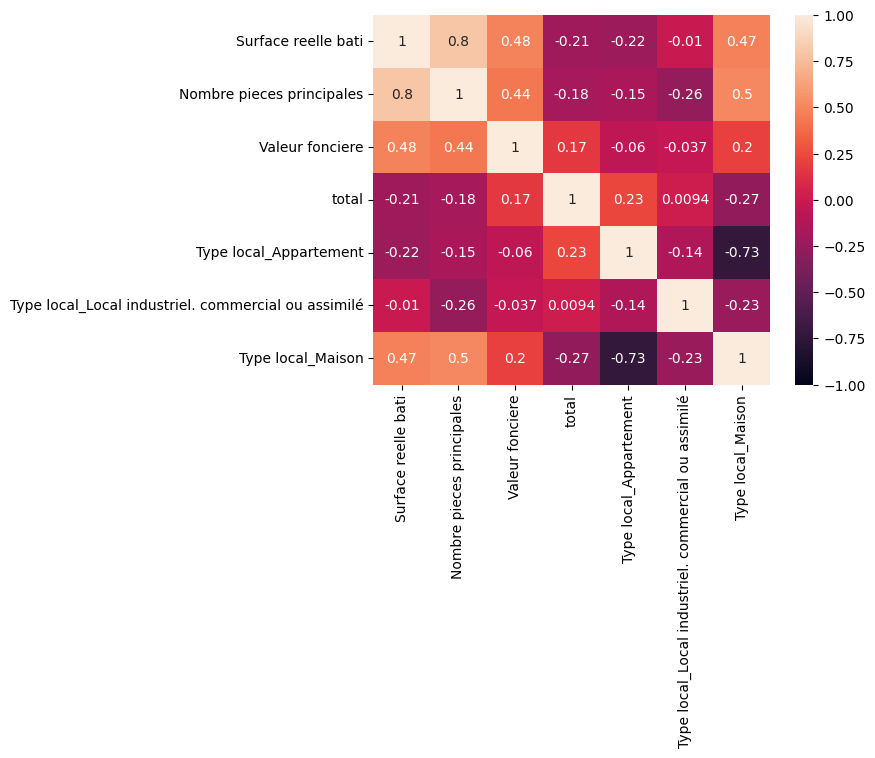

In [206]:
sns.heatmap(df2.corr(), vmax=1, vmin=-1, annot=True)

In [207]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math

In [208]:
target = 'Valeur fonciere'

In [209]:
X = df2.drop(target, axis=1)
y = df2[target]

In [210]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [211]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3)

In [212]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2Score = r2_score(y_test, y_pred)

In [213]:
rmse

69024.77215583903

In [214]:
r2Score

0.3816665440168623

In [221]:
model = RandomForestRegressor(max_depth=9, min_samples_leaf=5, min_samples_split=400, n_estimators=150, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2Score = r2_score(y_test, y_pred)

In [222]:
rmse

64859.92019965031

In [223]:
r2Score

0.45403399497069397

In [218]:
import pickle

In [219]:
with open("./assets/models/random-forest-regressor.pkl", "wb") as f:
    pickle.dump({'model': model}, f)